# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 3 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = \frac{1}{\pi}\cos(\pi x)
$$

Periodic BC.

Domain: $[-0.25, 0.25]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(\frac{1}{\pi}\cos(\pi x)/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(\frac{1}{\pi}\cos(\pi x)/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$

In [1]:
NAME = "1"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [5]:
key = random.PRNGKey(1001)
key, subkey = random.split(key, 2)

layers = [3] + [64]*4 + [2] # (cos(2pi*x), sin(2pi*x), t) -> (u, v)
c0 = 6.0
w0 = jnp.array([[1.0], [1.0], [100.0]]) # (w_x, w_t)
# w0 = 10.0
w1 = 1.0
lambda_0 = 1e-6
direct_params = init_siren_params(subkey, layers, c0, w0, w1)
# direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[-0.25, 0.], [0.25, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]
epsilon = 1.0
V = 0.0

# @jax.jit
# def 

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1] <- enforce periodic bc
# 	xt = jnp.sin(2.0*jnp.pi*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - jnp.pi)
# 	xt = jnp.sin(2*jnp.pi*xt/(domain[1, :]-domain[0, :]))

	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[0], jnp.sin(2*jnp.pi*xt[0]/spatial_width))
	xt = index_update(xt, index[1], jnp.cos(2*jnp.pi*xt[1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [6]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	return loss_c, loss_d


@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + l2_regularization(params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d, loss_c, loss_d

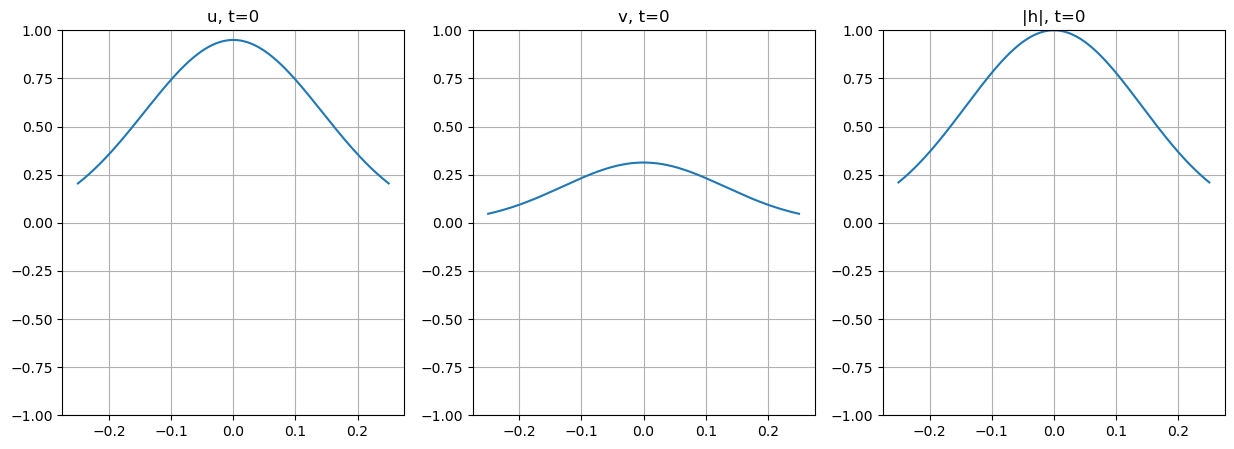

In [7]:
u0_fn = lambda x, t: np.exp(-25*x**2)*np.cos(1/(np.pi*epsilon)*np.cos(np.pi*x))
v0_fn = lambda x, t: np.exp(-25*x**2)*np.sin(1/(np.pi*epsilon)*np.cos(np.pi*x))
x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 1000
x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_cx = 1000
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))

class Time_Marching_Generator:
	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.spatial_points = spatial_points
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = -1
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self.spatial_points, self._t

In [8]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 200000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1000}
weights = {"c": 1e-2, "d": 1.0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, [0, 0], n_cx, iterations, 1)

params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/11, 22:04:11, Iteration: 0, Train Loss: 5.7098e+00, c: 4.6370e+02, d: 1.0729e+00
2020/08/11, 22:04:18, Iteration: 1000, Train Loss: 8.9667e-02, c: 8.0155e+00, d: 9.5121e-03
2020/08/11, 22:04:25, Iteration: 2000, Train Loss: 7.5820e-02, c: 5.8025e+00, d: 1.7794e-02
2020/08/11, 22:04:33, Iteration: 3000, Train Loss: 5.8465e-02, c: 4.5106e+00, d: 1.3360e-02
2020/08/11, 22:04:40, Iteration: 4000, Train Loss: 5.0250e-02, c: 3.7480e+00, d: 1.2770e-02
2020/08/11, 22:04:47, Iteration: 5000, Train Loss: 4.1305e-02, c: 3.0383e+00, d: 1.0922e-02
2020/08/11, 22:04:54, Iteration: 6000, Train Loss: 5.2353e-02, c: 3.6923e+00, d: 1.5430e-02
2020/08/11, 22:05:01, Iteration: 7000, Train Loss: 5.0564e-02, c: 3.8924e+00, d: 1.1640e-02
2020/08/11, 22:05:08, Iteration: 8000, Train Loss: 3.4300e-02, c: 2.1486e+00, d: 1.2814e-02
2020/08/11, 22:05:15, Iteration: 9000, Train Loss: 2.8945e-02, c: 2.2120e+00, d: 6.8249e-03
2020/08/11, 22:05:23, Iteration: 10000, Train Loss: 2.8461e-02, c: 2.0652e+00, d: 7

2020/08/11, 22:15:21, Iteration: 89000, Train Loss: 6.2337e-03, c: 8.6652e-02, d: 5.3672e-03
2020/08/11, 22:15:29, Iteration: 90000, Train Loss: 4.3482e-03, c: 1.6317e-01, d: 2.7165e-03
2020/08/11, 22:15:36, Iteration: 91000, Train Loss: 2.5790e-03, c: 8.1755e-02, d: 1.7615e-03
2020/08/11, 22:15:44, Iteration: 92000, Train Loss: 2.9464e-03, c: 1.2009e-01, d: 1.7455e-03
2020/08/11, 22:15:51, Iteration: 93000, Train Loss: 6.3604e-03, c: 1.8711e-01, d: 4.4893e-03
2020/08/11, 22:15:59, Iteration: 94000, Train Loss: 4.3906e-03, c: 1.2344e-01, d: 3.1562e-03
2020/08/11, 22:16:07, Iteration: 95000, Train Loss: 5.3233e-03, c: 1.2337e-01, d: 4.0895e-03
2020/08/11, 22:16:14, Iteration: 96000, Train Loss: 6.6488e-03, c: 1.4292e-01, d: 5.2196e-03
2020/08/11, 22:16:22, Iteration: 97000, Train Loss: 4.0242e-03, c: 6.7718e-02, d: 3.3470e-03
2020/08/11, 22:16:29, Iteration: 98000, Train Loss: 4.0791e-03, c: 7.5109e-02, d: 3.3280e-03
2020/08/11, 22:16:37, Iteration: 99000, Train Loss: 4.2646e-03, c: 1.1

2020/08/11, 22:26:28, Iteration: 177000, Train Loss: 4.1285e-03, c: 5.6307e-02, d: 3.5655e-03
2020/08/11, 22:26:36, Iteration: 178000, Train Loss: 1.7527e-03, c: 5.8906e-02, d: 1.1636e-03
2020/08/11, 22:26:43, Iteration: 179000, Train Loss: 4.4283e-03, c: 5.6508e-02, d: 3.8632e-03
2020/08/11, 22:26:51, Iteration: 180000, Train Loss: 2.4170e-03, c: 4.7936e-02, d: 1.9377e-03
2020/08/11, 22:26:59, Iteration: 181000, Train Loss: 4.1830e-03, c: 5.9579e-02, d: 3.5872e-03
2020/08/11, 22:27:06, Iteration: 182000, Train Loss: 2.4633e-03, c: 5.9762e-02, d: 1.8657e-03
2020/08/11, 22:27:14, Iteration: 183000, Train Loss: 4.7955e-03, c: 8.7330e-02, d: 3.9222e-03
2020/08/11, 22:27:21, Iteration: 184000, Train Loss: 1.9590e-03, c: 4.8757e-02, d: 1.4714e-03
2020/08/11, 22:27:29, Iteration: 185000, Train Loss: 2.7260e-03, c: 8.2943e-02, d: 1.8965e-03
2020/08/11, 22:27:37, Iteration: 186000, Train Loss: 3.9855e-03, c: 2.9039e-02, d: 3.6951e-03
2020/08/11, 22:27:44, Iteration: 187000, Train Loss: 3.9095e

In [ ]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 1000000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1000}
weights = {"c": 1e-2, "d": 1.0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, domain[:, 1], n_cx, iterations, 1)

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

In [9]:
from scipy.io import loadmat

uv_true = loadmat("ex3_epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-0.25, 0.25])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 501)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 10, blit = True)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
duv_dxt_c = jacobian(get_params(opt_state), jnp.hstack([collocation.x, collocation.t]))
du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
du_dt_c